In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
import math
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spy-dataset/SPY.csv


### Load Data

In [2]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
df = pd.read_csv('../SPY.csv')
#df = df.drop('Unnamed: 0', axis=1)
df['Date'] = df['Date'].astype('datetime64[ns]')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,90.790062,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
...,...,...,...,...,...,...,...
2836,2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2837,2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2838,2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900
2839,2021-04-15,413.739990,416.160004,413.690002,415.869995,415.869995,60229800


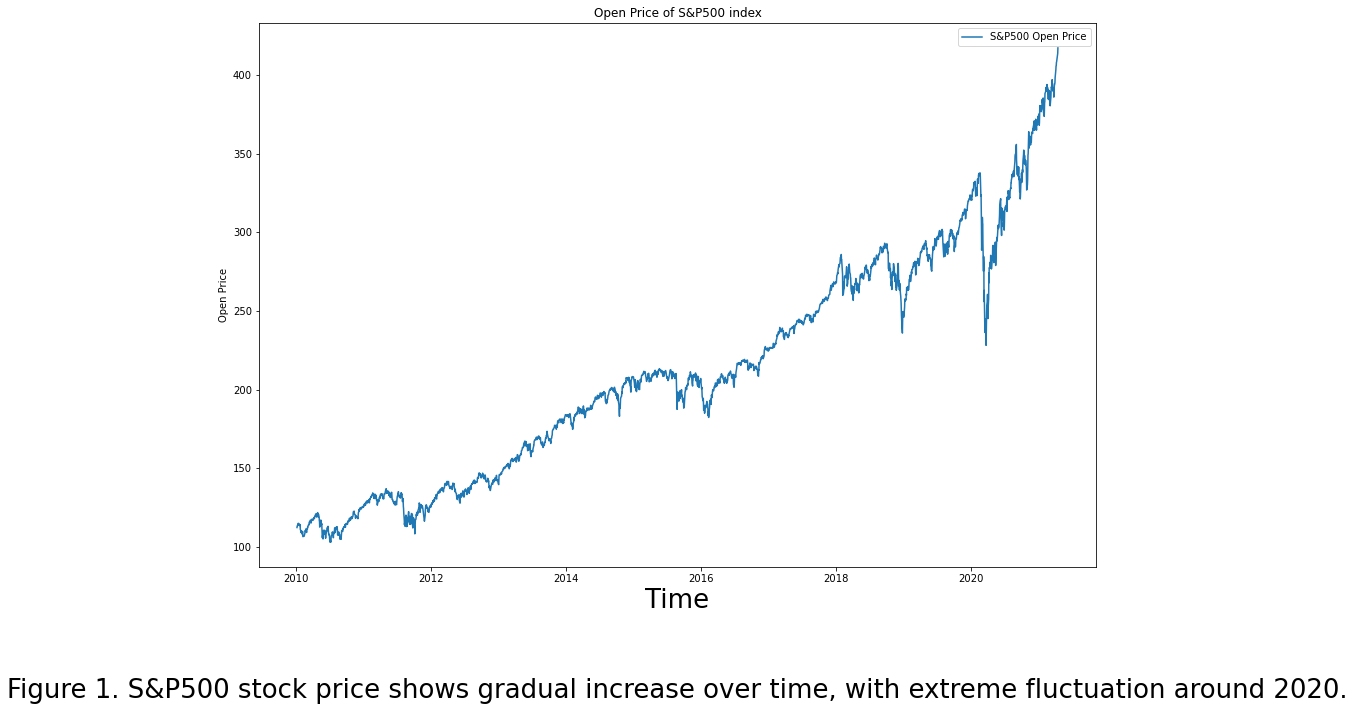

In [9]:
plt.figure(figsize=(15,10))
plt.plot(df['Date'], df['Open'], label='S&P500 Open Price')
plt.xlabel('''Time\n\n 
Figure 1. S&P500 stock price shows gradual increase over time, with extreme fluctuation around 2020.''', fontsize=26)
plt.ylabel('Open Price')
plt.title('Open Price of S&P500 index')
plt.legend()
plt.show()

In [3]:
# Create a new dataframe with only the 'Open column 
data = df.filter(['Open'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .9384 ))

training_data_len

2666

In [4]:
df.loc[training_data_len]

Date         2020-08-06 00:00:00
Open                  331.480011
High                  334.459991
Low                   331.130005
Close                 334.329987
Adj Close             330.501129
Volume                  43679400
Name: 2666, dtype: object

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02947731],
       [0.03231044],
       [0.03313808],
       ...,
       [0.9859298 ],
       [0.98882661],
       [1.        ]])

In [6]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.02947731, 0.03231044, 0.03313808, 0.03307442, 0.0343159 ,
       0.03810403, 0.03457057, 0.0345069 , 0.03622588, 0.03698988,
       0.03345643, 0.03555739, 0.0344114 , 0.02575284, 0.02260138,
       0.01983191, 0.01929075, 0.02253773, 0.01887693, 0.01604381,
       0.01957726, 0.02155089, 0.01868594, 0.01098236, 0.01155535,
       0.01279683, 0.01254219, 0.01196919, 0.01235117, 0.01830394,
       0.02279237, 0.02218756, 0.02390654, 0.02686701, 0.02467053,
       0.02237855, 0.01951358, 0.02438402, 0.02575284, 0.02947731,
       0.02985929, 0.02973195, 0.0326606 , 0.03549373, 0.03444324,
       0.03628956, 0.03689437, 0.04087348, 0.03867703, 0.04042783,
       0.04345197, 0.04456612, 0.04093716, 0.03883618, 0.04345197,
       0.04412046, 0.04622142, 0.04380213, 0.04475711, 0.04568026])]
[0.04405677737332647]

[array([0.02947731, 0.03231044, 0.03313808, 0.03307442, 0.0343159 ,
       0.03810403, 0.03457057, 0.0345069 , 0.03622588, 0.03698988,
       0.03345643, 0.03555739, 0.03

In [7]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(70, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2606/2606 [==============================] - 87s 32ms/step - loss: 0.0020
Epoch 2/5
2606/2606 [==============================] - 84s 32ms/step - loss: 4.0354e-04
Epoch 3/5
2606/2606 [==============================] - 84s 32ms/step - loss: 3.1337e-04
Epoch 4/5
2606/2606 [==============================] - 84s 32ms/step - loss: 2.2918e-04
Epoch 5/5
2606/2606 [==============================] - 84s 32ms/step - loss: 2.2071e-04


In [8]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Test RMSE:', rmse)

Test RMSE: 5.922002907490621


In [9]:
# TEST RMSE (Without Dropout): Test RMSE: 19.8656
# TEST RMSE (With Dropout): Test RMSE: 8.467475760545556
# TEST RMSE (With 1 more layer): 4.485413255420926

In [10]:
print(predictions[0:5])
df[training_data_len+1:training_data_len+5]

[[338.47528]
 [338.94443]
 [340.4244 ]
 [342.16782]
 [343.89163]]


,Date,Open,High,Low,Close,Adj Close,Volume
2667,2020-08-07,333.279999,334.880005,332.299988,334.570007,330.738403,57308300
2668,2020-08-10,335.059998,335.769989,332.959991,335.570007,331.726929,44282100
2669,2020-08-11,336.850006,337.540009,332.010010,332.799988,328.988647,69601100
2670,2020-08-12,335.440002,338.279999,335.410004,337.440002,333.575531,53826100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


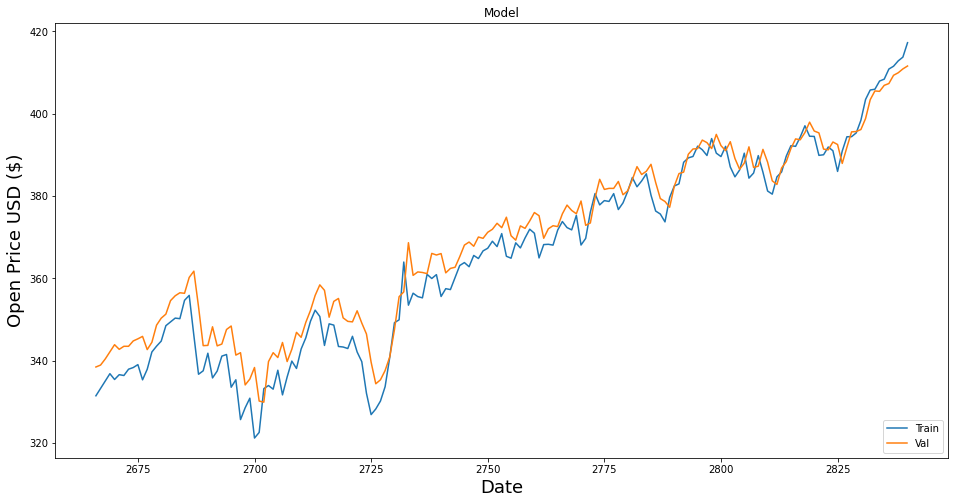

In [11]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
#plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Agent

In [12]:
# Determine when to excecute the strategies
class LSTM_Agent:
    
    def __init__(self, wallet):
        self.data = None
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.input = None # Prediction input
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.all_hist = [[],[]] # date prediction
        self.percent_gains = []
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
    
    def shape_input(self, idx):
        #print('In Shape Input')
        temp = [np.array(self.data['Scaled_Open'].iloc[idx-60:idx])]
        self.input = np.reshape(temp, (1, 60, 1 ))
        #print(self.input)
        
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self):
        pred = model.predict(self.input)
        pred = self.scaler.inverse_transform(pred)[0][0]
        #print('pred', pred)
        self.all_hist[0].append(self.current_market['Date'])
        self.all_hist[1].append(pred)
        current_price = self.current_market['Open']
        #print('current_price', current_price)
        #print('Predict:', pred, 'Current:', current_price)
        percent_gain = 100*(pred-current_price)/current_price
        self.percent_gains.append(percent_gain)
        if percent_gain > 2 and self.can_buy(-1):
            # Buy signal
            #print('BUY! ','Predict:', pred, 'Current:', current_price)
            self.buy(-1)
        elif percent_gain < -2 and self.can_sell(-1):
            # sell signal
            #print('SELL! ','Predict:', pred, 'Current:', current_price)
            self.sell(-1)
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self, data):
        scaled_data = self.scaler.fit_transform(data[['Open']].values)
        data['Scaled_Open'] = scaled_data
        self.data = data.reset_index()
        print(self.data.head())
        for (idx, row) in self.data.iterrows():
            self.current_market = data.iloc[idx]
            
            if idx > 59: # first day where model can make prediction
                self.shape_input(idx)
                self.strategy()
        
                #break
        return self.history

In [13]:
timeline1 = df[(df['Date'] >= '2011-10-14') & (df['Date'] <= '2013-08-01')]
timeline2 = df[(df['Date'] >= '2020-08-07') & (df['Date'] <= '2021-02-26')]
timeline_main = df[(df['Date'] >= '2020-08-07') & (df['Date'] <= '2021-04-16')]

In [14]:
# Subtracting 60 days from the intended test timeline as the model 
# requires 60 days worth of prior data to make predictions. 
timeline1 = df[390:901]
timeline2 = df[2607:2807]
timeline_main = df[2607:2841]

# Timeline Main

In [17]:
# Inputs
invest = 1000
agent = LSTM_Agent(invest)
buy_info, sell_info = agent.deploy(timeline_main)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   index       Date        Open        High         Low       Close  \
0   2607 2020-05-13  286.059998  287.190002  278.959991  281.600006   
1   2608 2020-05-14  278.950012  285.109985  272.989990  284.970001   
2   2609 2020-05-15  282.369995  286.329987  281.339996  286.279999   
3   2610 2020-05-18  293.049988  296.750000  292.700012  295.000000   
4   2611 2020-05-19  294.350006  296.209991  291.950012  291.970001   

    Adj Close     Volume  Scaled_Open  
0  277.155365  144721100     0.051410  
1  280.472198  121977900     0.000000  
2  281.761536  111146300     0.024729  
3  290.343842  120320200     0.101952  
4  287.361664   95189300     0.111352  


In [18]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
#print('Baseline:', 100*(timeline_main.iloc[-1].Open-timeline_main.iloc[0].Open)/timeline_main.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1166.23999
Percentage gain: 16.623999000000005 %



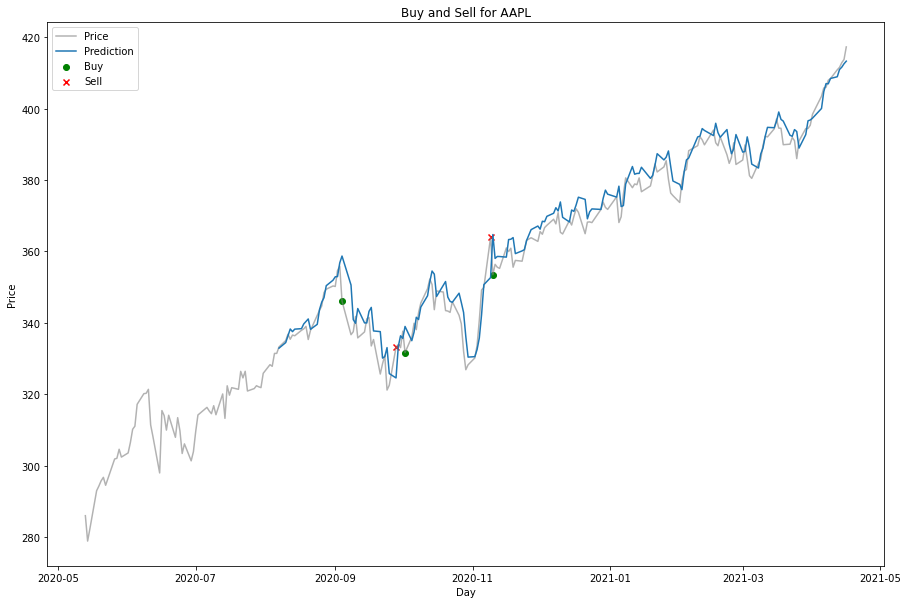

In [19]:
# Visualize SMAs and prices
plt.figure(figsize=(15,10))
plt.plot(timeline_main[['Date']], timeline_main[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

plt.plot(agent.all_hist[0], agent.all_hist[1], label='Prediction')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

# Timeline 2

In [20]:
# Inputs
invest = 1000
agent = LSTM_Agent(invest)
buy_info, sell_info = agent.deploy(timeline2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   index       Date        Open        High         Low       Close  \
0   2607 2020-05-13  286.059998  287.190002  278.959991  281.600006   
1   2608 2020-05-14  278.950012  285.109985  272.989990  284.970001   
2   2609 2020-05-15  282.369995  286.329987  281.339996  286.279999   
3   2610 2020-05-18  293.049988  296.750000  292.700012  295.000000   
4   2611 2020-05-19  294.350006  296.209991  291.950012  291.970001   

    Adj Close     Volume  Scaled_Open  
0  277.155365  144721100     0.061821  
1  280.472198  121977900     0.000000  
2  281.761536  111146300     0.029736  
3  290.343842  120320200     0.122598  
4  287.361664   95189300     0.133901  


In [21]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
#print('Baseline:', 100*(timeline2.iloc[-1].Open-timeline2.iloc[0].Open)/timeline2.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1100.4400020000003
Percentage gain: 10.044000200000028 %



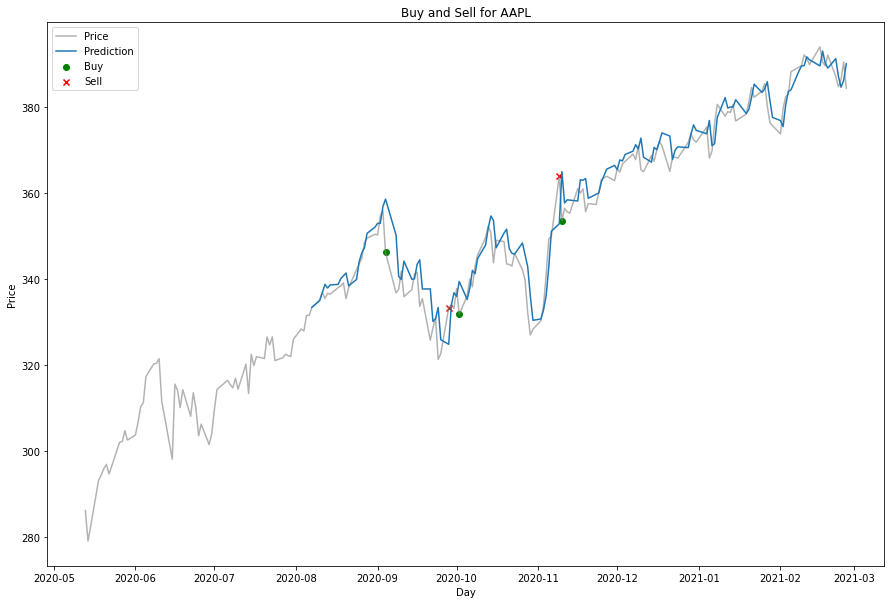

In [22]:
# Visualize SMAs and prices
plt.figure(figsize=(15,10))
plt.plot(timeline2[['Date']], timeline2[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

plt.plot(agent.all_hist[0], agent.all_hist[1], label='Prediction')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

# Timeline 1

In [23]:
# Inputs
invest = 1000
agent = LSTM_Agent(invest)
buy_info, sell_info = agent.deploy(timeline1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   index       Date        Open        High         Low       Close  \
0    390 2011-07-21  133.399994  134.820007  132.669998  134.490005   
1    391 2011-07-22  134.520004  134.720001  133.759995  134.580002   
2    392 2011-07-25  133.300003  134.490005  133.160004  133.830002   
3    393 2011-07-26  133.740005  133.960007  133.029999  133.330002   
4    394 2011-07-27  132.589996  132.630005  130.429993  130.600006   

    Adj Close     Volume  Scaled_Open  
0  110.880898  245246300     0.406392  
1  110.955109  126019400     0.424562  
2  110.336769  136653800     0.404770  
3  109.924522  131278200     0.411908  
4  107.673775  249020100     0.393251  


In [24]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
#print('Baseline:', 100*(timeline2.iloc[-1].Open-timeline2.iloc[0].Open)/timeline2.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1338.7300659999999
Percentage gain: 33.87300659999999 %



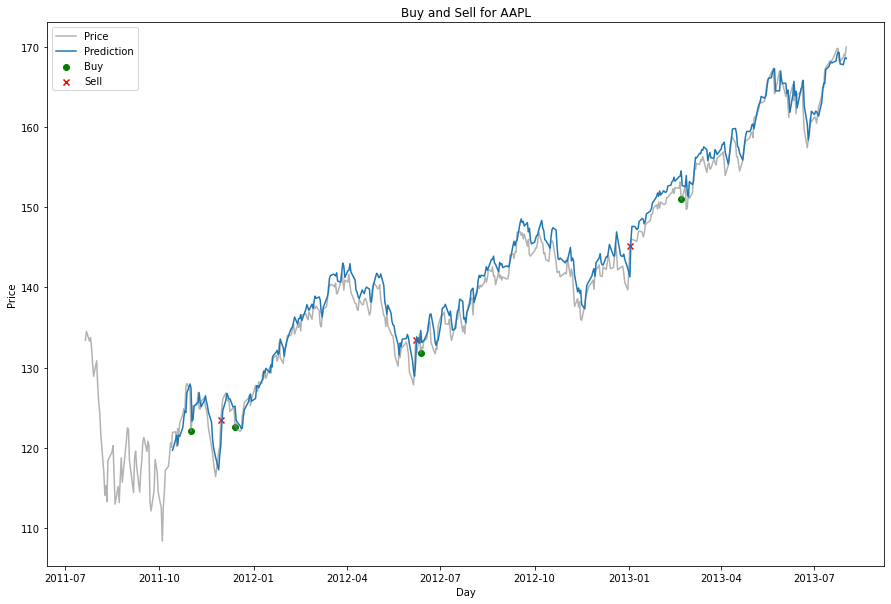

In [25]:
# Visualize SMAs and prices
plt.figure(figsize=(15,10))
plt.plot(timeline1[['Date']], timeline1[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

plt.plot(agent.all_hist[0], agent.all_hist[1], label='Prediction')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()